In [1]:
import pandas as pd
import re
from textblob import TextBlob
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# load the dataset
df = pd.read_csv('../data/LGBT_Tweets_processed.csv')

In [2]:
# all lowercase
df.tweet = df.tweet.str.lower()

#Remove twitter handlers
df.tweet = df.tweet.apply(lambda x:re.sub('@[^\s]+','',x))

# remove url
df.tweet = df.tweet.apply(lambda x:re.sub(r"http\S+", "", x))

# Substituting multiple spaces to single space
df.tweet = df.tweet.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#remove hashtags
df.tweet = df.tweet.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove all single characters
df.tweet = df.tweet.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

In [3]:
#Perform sentiment analysis using TextBlob on data
df['sentiment'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'Neutral'))

In [4]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["tweet"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = df["tweet"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.110454,0.215753,0.162220,-0.174460,-0.013160
1,-0.004694,0.149461,-0.027395,-0.107862,0.242168
2,-0.323506,-0.075006,-0.159341,-0.606084,0.226632
3,-0.327943,-0.079433,-0.161475,-0.077290,0.408970
4,-0.096479,0.057709,0.182611,0.010903,-0.051120
...,...,...,...,...,...
32451,0.088128,0.111880,0.064776,-0.056514,-0.040436
32452,-0.018540,0.144621,0.017063,-0.069888,0.056860
32453,0.003267,0.440957,0.071016,-0.091587,0.113335
32454,0.014478,0.209769,-0.037478,-0.430747,0.222933


In [5]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['tweet'])

In [6]:
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,doc2vec_df],axis=1)
modelling_features.shape

(32456, 10005)

In [7]:
modelling_features

array([[ 0.        ,  0.        ,  0.        , ...,  0.16221964,
        -0.17446032, -0.01316025],
       [ 0.        ,  0.        ,  0.        , ..., -0.02739499,
        -0.1078617 ,  0.24216804],
       [ 0.        ,  0.        ,  0.        , ..., -0.1593405 ,
        -0.60608387,  0.22663231],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.0710164 ,
        -0.09158742,  0.11333459],
       [ 0.        ,  0.        ,  0.        , ..., -0.03747802,
        -0.430747  ,  0.22293293],
       [ 0.        ,  0.        ,  0.        , ...,  0.57844448,
        -0.74175513, -0.19226356]])

# Train different models with TFIDF and doc2vec

## Random Forest

In [8]:
X = pd.DataFrame(modelling_features)
y = df['sentiment_label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc)

              precision    recall  f1-score   support

     Neutral       0.78      0.73      0.76      1875
    negative       0.94      0.27      0.42      1550
    positive       0.66      0.92      0.77      3067

    accuracy                           0.71      6492
   macro avg       0.79      0.64      0.65      6492
weighted avg       0.76      0.71      0.68      6492

Random Forest, Accuracy Score: 0.7136475662353666


## Logistic Regression

In [9]:
X = pd.DataFrame(modelling_features)
y = df['sentiment_label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression(solver='lbfgs', max_iter=5000).fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc1 = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc1)

              precision    recall  f1-score   support

     Neutral       0.82      0.86      0.84      1875
    negative       0.84      0.64      0.73      1550
    positive       0.83      0.91      0.86      3067

    accuracy                           0.83      6492
   macro avg       0.83      0.80      0.81      6492
weighted avg       0.83      0.83      0.82      6492

Logistic Regression, Accuracy Score: 0.827634011090573


## Naive Bayes

In [10]:
X = pd.DataFrame(modelling_features)
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

     Neutral       0.69      0.79      0.74      1875
    negative       0.40      0.72      0.51      1550
    positive       0.82      0.42      0.55      3067

    accuracy                           0.60      6492
   macro avg       0.64      0.64      0.60      6492
weighted avg       0.68      0.60      0.60      6492

Naive Bayes, Accuracy Score: 0.5962723351817621


## SVM

In [11]:
X = pd.DataFrame(modelling_features)
y = df['sentiment_label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

     Neutral       0.84      0.89      0.87      1875
    negative       0.83      0.73      0.78      1550
    positive       0.88      0.90      0.89      3067

    accuracy                           0.86      6492
   macro avg       0.85      0.84      0.84      6492
weighted avg       0.86      0.86      0.86      6492

SVM, Accuracy Score: 0.8570548367221196


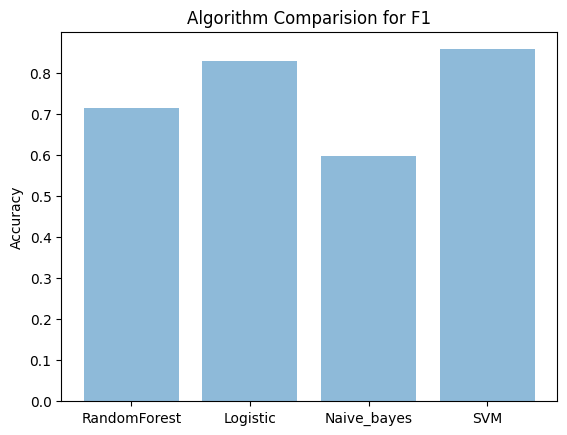

In [12]:
objects = ('RandomForest','Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

## Comparing results from 2 processes of training

In [13]:
tfidf_result = np.array([0.7301293900184843, 0.8279420825631546, 0.5817929759704251, 0.8561306223043746])
tfidf_doc2vector_result = np.array([acc, acc1, acc2, acc3])

columns=['random forest', 'logistic regression', 'naive bayes', 'svm']
df_tfidf_result = pd.DataFrame(np.reshape(tfidf_result, (1,len(tfidf_result))),columns=columns)
df_tfidf_doc2vector_result = pd.DataFrame(np.reshape(tfidf_doc2vector_result, (1,len(tfidf_doc2vector_result))),columns=columns)

In [14]:
df_tfidf_result

,random forest,logistic regression,naive bayes,svm
0,0.730129,0.827942,0.581793,0.856131


In [15]:
df_tfidf_doc2vector_result

,random forest,logistic regression,naive bayes,svm
0,0.713648,0.827634,0.596272,0.857055


In [16]:
df_merged = pd.concat([df_tfidf_result, df_tfidf_doc2vector_result], ignore_index=True, sort=False)
df_merged

,random forest,logistic regression,naive bayes,svm
0,0.730129,0.827942,0.581793,0.856131
1,0.713648,0.827634,0.596272,0.857055


In [21]:
df_merged = df_merged.T
df_merged.rename(columns={0: 'tfidf_result', 1: 'tfidf_doc2vector'}, inplace=True)
df_merged

,tfidf_result,tfidf_doc2vector
random forest,0.730129,0.713648
logistic regression,0.827942,0.827634
naive bayes,0.581793,0.596272
svm,0.856131,0.857055


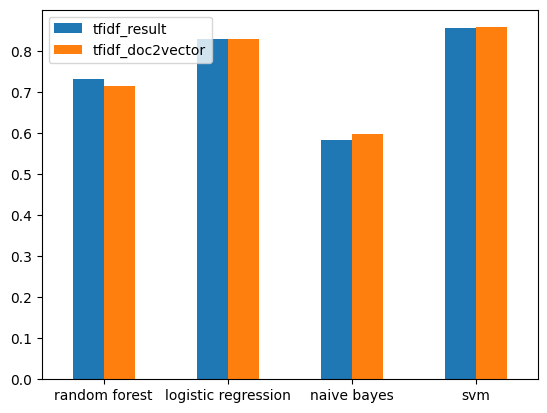

In [22]:
ax = df_merged.plot(y=[0, 1], kind="bar", rot=0)

# Summary

- After adding doc2vec as an additional feature, the result of random forest decreased but the results of other models are slightly better. They also took so much longer to train.
- SVM still provides the best result with the additional feature.